# Import Libraries

In [1]:
import cv2
from craft_text_detector import Craft
import math
import numpy as np
import matplotlib.pyplot as plt

# Load Model

In [3]:
craft = Craft( crop_type="box", cuda=True)
# craft_box = Craft(crop_type = "box" , cuda=True)

c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Ghost\anaconda3\envs\galli_maps\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [4]:
def convert_coordinates_to_int(box):
    for point in box:
        point[0] = int(round(point[0]))
        point[1] = int(round(point[1]))

def get_max_angled_rectangle(boxes):
    angled_boxes = []
    for box in boxes:
        if len(box) >= 3:
            box_points = np.array(box, dtype=np.int32).reshape(-1, 2)
            rotated_rect = cv2.minAreaRect(box_points)
            box_vertices = cv2.boxPoints(rotated_rect)
            box_vertices = np.int0(box_vertices)
            angled_boxes.append(box_vertices)
    largest_contour = max(angled_boxes, key=cv2.contourArea)
    return largest_contour

def get_max_straight_rectangle(boxes):
    straight_boxes = []
    for box in boxes:
        flat_box = box.flatten()
        x_min = round(min([flat_box[x] for x in [0,2,4,6]]))
        y_min = round(min([flat_box[y] for y in [1,3,5,7]]))
        x_max = round(max([flat_box[x] for x in [0,2,4,6]]))
        y_max = round(max([flat_box[y] for y in [1,3,5,7]]))
        
        # Create the array with correct format
        box_vertices = np.array([
            [x_min, y_min],
            [x_min, y_max],
            [x_max, y_max],
            [x_max, y_min]
        ], dtype=np.int32)
        
        straight_boxes.append(box_vertices)
    largest_contour = max(straight_boxes, key=cv2.contourArea)
    return largest_contour


In [5]:
def clockwise(contour):
    contour = contour.reshape(-1, 2)

    # Calculate the centroid of the contour
    centroid = np.mean(contour, axis=0)

    # Calculate angles from centroid to points
    angles = np.arctan2(contour[:, 1] - centroid[1], contour[:, 0] - centroid[0])

    # Sort points based on angles
    sorted_indices = np.argsort(angles)
    sorted_contour = contour[sorted_indices]

    return sorted_contour

Original : 
 [[  0 224]
 [208 170]
 [220 216]
 [ 11 270]]
After : 
 [[208 170]
 [220 216]
 [ 11 270]
 [  0 224]]
Normal Angle : 75.51312255859375
Clockwise Angle : 75.51312255859375


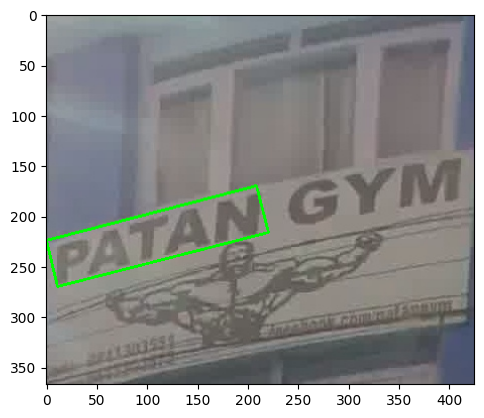

In [6]:
img = cv2.imread('images/odd_5.jpg')
image = img.copy()
boxes = craft.detect_text(img)['boxes']

largest_contour = get_max_angled_rectangle(boxes)
clockwise_largest_contour = clockwise(largest_contour)

print(f'Original : \n {largest_contour}')
print(f'After : \n {clockwise_largest_contour}')


_,_,angle = cv2.minAreaRect(largest_contour)
print(f'Normal Angle : {angle}')
_,_,angle = cv2.minAreaRect(clockwise_largest_contour)
print(f'Clockwise Angle : {angle}')

cv2.drawContours(image,[largest_contour],0,(255,0,0),2)
cv2.drawContours(image,[clockwise_largest_contour],0,(0,255,0),2)


plt.imshow(image)
plt.show()

In [15]:
rows,cols = img.shape[:2]
[vx,vy,x,y] = cv2.fitLine(largest_contour, cv2.DIST_L2,0,0.01,0.01)
lefty = (-x*vy/vx) + y
righty = ((cols-x)*vy/vx)+y
# cv2.line(img,(cols-1,righty),(0,lefty),(0,255,0),2)

# plt.imshow(img)

In [16]:
lefty

array([248.47469], dtype=float32)

In [8]:
angle_rad = np.arctan2(vy, vx)
angle_deg = np.degrees(angle_rad)

In [9]:
angle_deg[0]

-14.544716

In [10]:
height, width = img.shape[:2]
center = (width // 2, height // 2)

rotation_matrix = cv2.getRotationMatrix2D(center, angle_deg[0] , scale=1.0)
rotated_image = cv2.warpAffine(img, rotation_matrix , (width, height))  

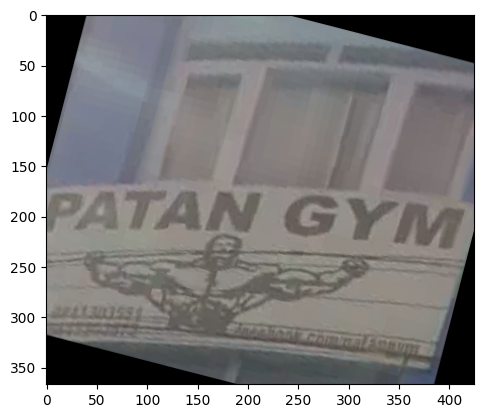

In [11]:
plt.imshow(rotated_image)